<div class="output_png output_subarea output_execute_result">
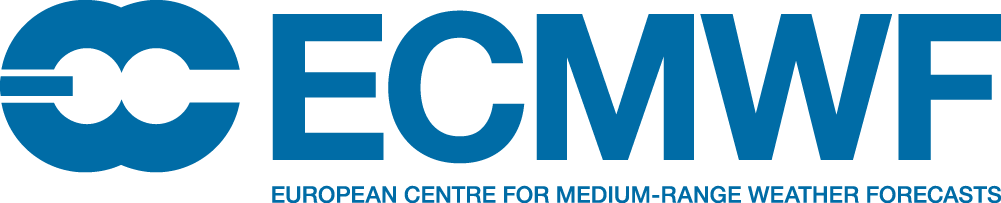
</div>

# 	Simulated images (WV) and Mean sea level pressure

This notebook will provide you guidance how to explore ECMWF data to produce the map from the ECMWF open charts web product.  
The original product can be found on this link: https://charts.ecmwf.int/products/medium-simulated-wv-wbpt  


<div class="output_png output_subarea output_execute_result">
<center>
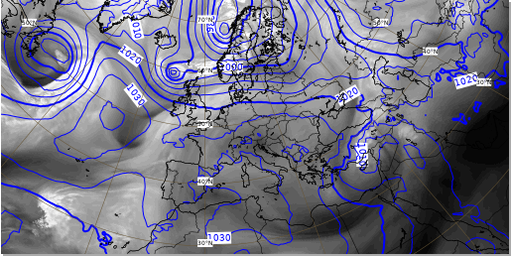</center>
</div>

Some ECMWF real-time products are governed by the [ECMWF Standard Licence Agreement](https://www.ecmwf.int/sites/default/files/ECMWF_Standard_Licence.pdf) and are not free or open. Access to these products depends on your use case. To find out which licence applies to you, please visit: [Use cases and licence conditions page](https://www.ecmwf.int/en/forecasts/accessing-forecasts/licences-available).  

To find out how to obtain the access to the ECMWF forecast data please visit our [Access page](https://www.ecmwf.int/en/forecasts/accessing-forecasts).

## Retrieve Data
This product takes in input 2 parameters:

* [Cloudy brightness temperature](https://codes.ecmwf.int/grib/param-db/260510) WV 6.2 µm (300 hPa) and 7.3 µm (500 hPa)
* [Mean sea level pressure](https://codes.ecmwf.int/grib/param-db/151)

In this example, we will use: 
- [**ecmwf-api-client**](https://pypi.org/project/ecmwf-api-client/) to download the data
- [**Metview**](https://metview.readthedocs.io/en/latest/) library to read, process and plot the data 

First we need to install them in the current Jupyter kernel:  
<div class="alert alert-block alert-info">
<b>Note:</b> If you are running the notebook on MyBinder or already have the libraries installed, go directly to importing the libraries.
</div>
<div class="alert alert-block alert-info">
<b>Note:</b> If you don't have these libraries installed, click on three dots below, uncomment the code and run the next cell.
</div>

In [1]:
#!pip install ecmwf-api-client metview metview-python

In [1]:
import metview as mv
from ecmwfapi import *
import requests

In [2]:
clbt_filename = "medium-simulated-wv-wbpt_clbt.grib"
msl_filename = "medium-simulated-wv-wbpt_msl.grib"

If you already have the access to the ECMWF archived forecast data, you can use the next two cells to download data from the [MARS archive](https://confluence.ecmwf.int/display/UDOC/MARS+user+documentation).  
Note that we have to do two API requests because the two parameters have diffeent 'type' which cannot be mixed.

In [ ]:
server = ECMWFService("mars")
server.execute(
    {
    "class": "od",
    "date": "-1",
    "expver": "1",
    "levtype": "sfc",
    "param": "260510",
    "step": "12",
    "stream": "oper",
    "time": "00",
    "type": "ssd",
    "channel":"5/6",
    "ident":"57",
    "grid": "0.25/0.25"
    },
    clbt_filename)

server.execute(
    {
    "class": "od",
    "date": "-1",
    "expver": "1",
    "levtype": "sfc",
    "param": "151",
    "step": "12",
    "stream": "oper",
    "time": "00",
    "type": "fc",
    "grid": "0.25/0.25"
    },
    msl_filename)

Alternatively we have prepared small sample dataset to explore

In [5]:
filenames = [clbt_filename, msl_filename]

for filename in filenames:
    url = f"https://get.ecmwf.int/repository/opencharts-sample-data/{filename}"
    r = requests.get(url)
    with open(filename, 'wb') as file:
        file.write(r.content)

## Reading and processing the data
Now we can use **Metview's read() function** to read the file.

In [3]:
clbt = mv.read(clbt_filename)
msl = mv.read(msl_filename)

The **describe()** function will give us the overview of the dataset.  

In [4]:
clbt.describe()

parameter,typeOfLevel,level,date,time,step,number,paramId,class,stream,type,experimentVersionNumber
clbt,None,,20220224,0,12,None,260510,od,oper,ssd,0001


And an overview of one parameter, where we can see more information, such as units or type of level.  

In [5]:
clbt.describe('clbt')

shortName,clbt
name,Cloudy brightness temperature
paramId,260510
units,K
typeOfLevel,None
level,
date,20220224
time,0
step,12
number,None
class,od


We can use **ls()** function to list all the fields in the file we downloaded.  

Note that this fieldset contains 2 fields, and the difference between them is the 'channel' key which is not one of the presented when we list the fields.

In [6]:
clbt.ls()

,centre,shortName,typeOfLevel,level,dataDate,dataTime,stepRange,dataType,number,gridType
Message,,,,,,,,,,
0,ecmf,clbt,None,<NA>,20220224,0,12,ssd,None,regular_ll
1,ecmf,clbt,None,<NA>,20220224,0,12,ssd,None,regular_ll


The grib file contains all the parameters, and we will use the select() function to filter what we need.

In [7]:
clbt_5 = clbt.select(channel= 5)
clbt_6 = clbt.select(channel= 6)

In order to be able to use the visual style from open charts, we need to convert the brightness temperature to Censius and Mean sea level pressure to hPa from Pa.

In [8]:
clbt_6 = clbt_6 - 273.15
clbt_5 = clbt_5 - 273.15
msl = msl / 100

## Plotting the data
And finally, we can plot the data on the map.   
First we will plot the data on 500 hPa (channel 6)

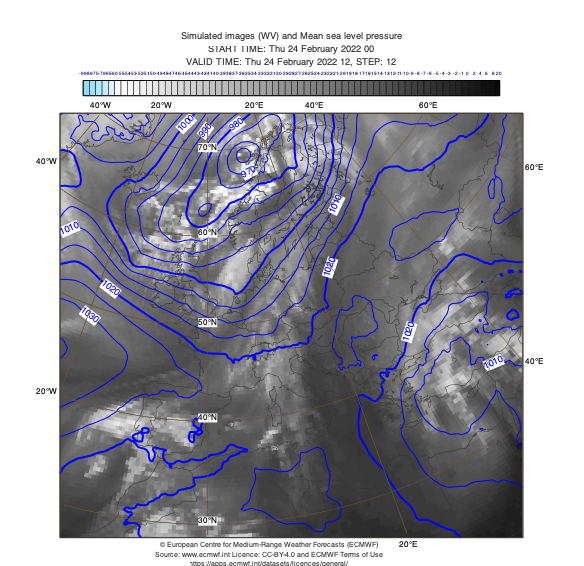

In [9]:
# define coastlines
coast = mv.mcoast(
    map_coastline_colour="charcoal",
    map_coastline_resolution="medium",
    map_coastline_land_shade="on",
    map_coastline_land_shade_colour="cream",
    map_coastline_sea_shade="off",
    map_boundaries="on",
    map_boundaries_colour= "charcoal",
    map_boundaries_thickness = 1,
    map_disputed_boundaries = "off",
    map_grid_colour="tan",
    map_label_height=0.35,
)

# define view
view = mv.geoview(
    area_mode="name",
    area_name="europe",
    coastlines=coast
)

#define styles
clbt_6_shade = mv.mcont(legend= "on",
                contour_automatics_settings = "style_name",
                contour_style_name = "sim_image_wv_500")

msl_shade = mv.mcont(legend= "off",
                contour_automatics_settings = "style_name",
                contour_style_name = "ct_blue_i5_t2")

title = mv.mtext(
    text_lines=["Simulated images (WV) and Mean sea level pressure", 
                "START TIME: <grib_info key='base-date' format='%a %d %B %Y %H' where='shortName=msl'/> ",
                "VALID TIME: <grib_info key='valid-date' format='%a %d %B %Y %H' where='shortName=msl'/>, STEP: <grib_info key='step' where='shortName=msl' />"],
    text_font_size=0.4,
    text_colour         = 'charcoal')

ecmwf_text = mv.mtext(    
    text_lines          = ["© European Centre for Medium-Range Weather Forecasts (ECMWF)",
                           "Source: www.ecmwf.int Licence: CC-BY-4.0 and ECMWF Terms of Use",
                            "https://apps.ecmwf.int/datasets/licences/general/"],
    text_justification  = 'center',
    text_font_size      = 0.3,
    text_mode           = "positional",
    text_box_x_position = 6.,
    text_box_y_position = -0.2,
    text_box_x_length   = 8,
    text_box_y_length   = 2,
    text_colour         = 'charcoal')

# generate plot
mv.setoutput('jupyter', plot_widget=False)
mv.plot(view, clbt_6, clbt_6_shade, msl, msl_shade, title, ecmwf_text)

And in the end we plot the Brightness temperature at level 300 hPa (channel 5).

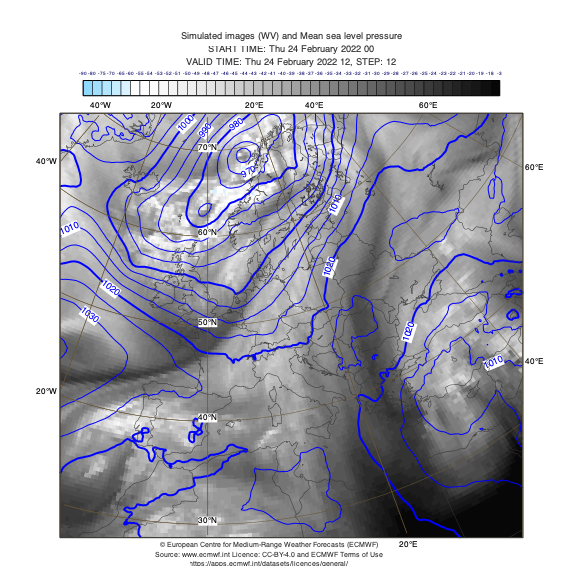

In [10]:
# define coastlines
coast = mv.mcoast(
    map_coastline_colour="charcoal",
    map_coastline_resolution="medium",
    map_coastline_land_shade="on",
    map_coastline_land_shade_colour="cream",
    map_coastline_sea_shade="off",
    map_boundaries="on",
    map_boundaries_colour= "charcoal",
    map_boundaries_thickness = 1,
    map_disputed_boundaries = "off",
    map_grid_colour="tan",
    map_label_height=0.35,
)

# define view
view = mv.geoview(
    area_mode="name",
    area_name="europe",
    coastlines=coast
)

#define styles
clbt_5_shade = mv.mcont(legend= "on",
                contour_automatics_settings = "style_name",
                contour_style_name = "sim_image_wv_fixed_range")

msl_shade = mv.mcont(legend= "off",
                contour_automatics_settings = "style_name",
                contour_style_name = "ct_blue_i5_t2")

title = mv.mtext(
    text_lines=["Simulated images (WV) and Mean sea level pressure", 
                "START TIME: <grib_info key='base-date' format='%a %d %B %Y %H' where='shortName=msl'/> ",
                "VALID TIME: <grib_info key='valid-date' format='%a %d %B %Y %H' where='shortName=msl'/>, STEP: <grib_info key='step' where='shortName=msl' />"],
    text_font_size=0.4,
    text_colour         = 'charcoal')

ecmwf_text = mv.mtext(    
    text_lines          = ["© European Centre for Medium-Range Weather Forecasts (ECMWF)",
                           "Source: www.ecmwf.int Licence: CC-BY-4.0 and ECMWF Terms of Use",
                            "https://apps.ecmwf.int/datasets/licences/general/"],
    text_justification  = 'center',
    text_font_size      = 0.3,
    text_mode           = "positional",
    text_box_x_position = 6.,
    text_box_y_position = -0.2,
    text_box_x_length   = 8,
    text_box_y_length   = 2,
    text_colour         = 'charcoal')

# generate plot
mv.setoutput('jupyter', plot_widget=False)
mv.plot(view, clbt_5, clbt_5_shade, msl, msl_shade, title, ecmwf_text)

To generate the png files you can run the following two cells.

In [11]:
png = mv.png_output(
      output_name = "medium-simulated-wv-wbpt-500",   # specify relative or full path
      output_title = "medium-simulated-wv-wbpt-500",    # title used by a viewer
      output_width = 1000,                 # set width in pixels
)
mv.setoutput(png)
mv.plot(view, clbt_6, clbt_6_shade, msl, msl_shade, title, ecmwf_text)

In [12]:
png = mv.png_output(
      output_name = "medium-simulated-wv-wbpt-300",   # specify relative or full path
      output_title = "medium-simulated-wv-wbpt-300",    # title used by a viewer
      output_width = 1000,                 # set width in pixels
)
mv.setoutput(png)
mv.plot(view, clbt_5, clbt_5_shade, msl, msl_shade, title, ecmwf_text)

Note that plot produced using this dataset will slightly differ from one from Open Charts. This is due to different resolution of the data.  
The data used here is on 0.25x0.25 resolution, while high resolution data is 0.1x0.1 grid.